Fine tuning Text Classification

Step-1 Importing the Libraries

In [ ]:
!pip install -U transformers datasets seaborn bertviz umap-learn

Step-2 Working with Dataset

In [2]:
from datasets import load_dataset
dataset=load_dataset("dair-ai/emotion")
dataset

README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [8]:
df=dataset['train'].to_pandas()
label_names=dataset['train'].features['label'].names
label_names

df['label_text']=df['label'].apply(lambda x:label_names[x])
df

,text,label,label_text
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger
...,...,...,...
15995,i just had a very brief time in the beanbag an...,0,sadness
15996,i am now turning and i feel pathetic that i am...,0,sadness
15997,i feel strong and good overall,1,joy
15998,i feel like this was such a rude comment and i...,3,anger


Analysis of Data using Matplotlib

In [9]:
import matplotlib.pyplot as plt

label_counts=df['label_text'].value_counts(ascending=True)

label_counts

,count
label_text,
surprise,572
love,1304
fear,1937
anger,2159
sadness,4666
joy,5362


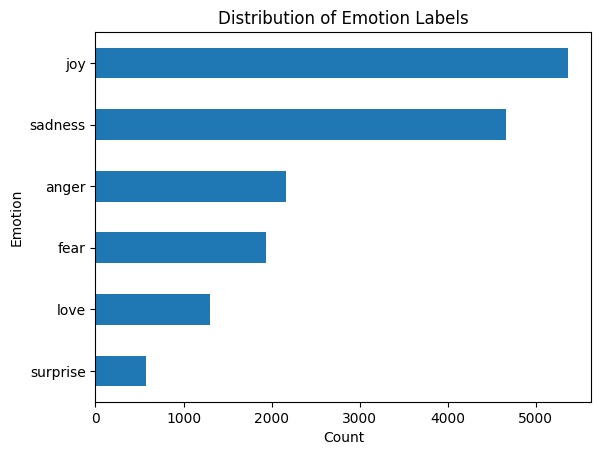

In [10]:
label_counts.plot(kind='barh')
plt.title('Distribution of Emotion Labels')
plt.xlabel('Count')
plt.ylabel('Emotion')
plt.show()

Tokenization of Data from the raw string

In [11]:
from transformers import AutoTokenizer
model_checkpoint='bert-base-cased'
tokenizer=AutoTokenizer.from_pretrained(model_checkpoint) #110M paramters

text="I love ML and ML is the future"
encode_text=tokenizer(text)
encode_text


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

{'input_ids': [101, 146, 1567, 150, 2162, 1105, 150, 2162, 1110, 1103, 2174, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Splitting the dataset into test,train and validation data

In [13]:
from sklearn.model_selection import train_test_split

#70% of data =Train data, 20% of data=Test data, 10% of data =Validation data

train,test=train_test_split(df,test_size=0.3,stratify=df['label_text'])
test,validation=train_test_split(test,test_size=1/3,stratify=test['label'])

train.shape,test.shape,validation.shape


((11200, 3), (3200, 3), (1600, 3))

In [14]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [16]:
from datasets import Dataset,DatasetDict

dataset=DatasetDict({
    'train':Dataset.from_pandas(train,preserve_index=False),
    'test':Dataset.from_pandas(test,preserve_index=False),
    'validation':Dataset.from_pandas(validation,preserve_index=False)
})
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 11200
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 3200
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 1600
    })
})

In [17]:
dataset['train'][0],dataset['test'][0],dataset['validation'][0]

({'text': 'i was doing some reading during a rather unpleasant plane ride the other day and didnt feel like reading unpleasant things so i skipped the uruk hai entirely and for the full reading experience should come back to it at some point',
  'label': 0,
  'label_text': 'sadness'},
 {'text': 'i was taunted by the ability of feeling threatened from weakness of frailty beneath this exterior of human existance lies a woman wanting nothing but a man needing his warmth and masculinity',
  'label': 4,
  'label_text': 'fear'},
 {'text': 'i feel like posting something clever problem is of course im not an extremely clever person',
  'label': 1,
  'label_text': 'joy'})

Tokenize all the text in Dataset

In [19]:
def tokenize(batch):
  return tokenizer(batch['text'],padding=True,truncation=True)

tokenize(dataset['train'][:3])

{'input_ids': [[101, 178, 1108, 1833, 1199, 3455, 1219, 170, 1897, 17178, 4261, 4176, 1103, 1168, 1285, 1105, 1238, 1204, 1631, 1176, 3455, 17178, 1614, 1177, 178, 18002, 1103, 190, 25192, 5871, 1182, 3665, 1105, 1111, 1103, 1554, 3455, 2541, 1431, 1435, 1171, 1106, 1122, 1120, 1199, 1553, 102], [101, 1165, 178, 1108, 1995, 178, 1400, 3210, 1107, 1103, 1278, 1114, 170, 1910, 178, 1125, 1106, 5152, 1149, 1104, 170, 2487, 1105, 2771, 170, 7574, 2759, 1344, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 178, 6613, 1106, 1435, 1283, 2296, 26984, 1118, 2146, 1115, 9762, 1172, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [20]:
encoded=dataset.map(tokenize,batched=True,batch_size=None)
encoded

Map:   0%|          | 0/11200 [00:00<?, ? examples/s]

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 11200
    })
    test: Dataset({
        features: ['text', 'label', 'label_text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3200
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1600
    })
})

Working with Models

In [23]:
from transformers import AutoModel

model=AutoModel.from_pretrained(model_checkpoint)

model.config.id2label,model.config.label2id

label2id={label:i for i ,label in enumerate(label_names)}
id2label={i:label for i ,label in enumerate(label_names)}

label2id,id2label

({'sadness': 0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5},
 {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'})

In [24]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [27]:
from transformers import AutoModelForSequenceClassification,AutoTokenizer,AutoConfig
import torch

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config=AutoConfig.from_pretrained(model_checkpoint,id2label=id2label,label2id=label2id)
model=AutoModelForSequenceClassification.from_pretrained(model_checkpoint,config=config)

model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

Model Training
1. Training Argument
2. Build the trainer along with the argument
3. Start the training itself

Evaluate the model =Compute metrics

In [ ]:
!pip install accelerate

In [62]:
from  transformers import TrainingArguments

batch_size=64
training_dir="bert_based_uncased_trained_model"

training_args=TrainingArguments(
    output_dir=training_dir,
    overwrite_output_dir=True,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_eval_batch_size=batch_size,
    per_device_train_batch_size=batch_size,
    weight_decay=0.01,
    eval_strategy="epoch",
    disable_tqdm=False,
    report_to='tensorboard',
    logging_strategy="epoch"

)

Build the compute metrics

In [63]:
from sklearn.metrics import accuracy_score,f1_score

def compute_metrics(pred):
  labels=pred.label_ids
  preds=pred.predictions.argmax(-1)
  f1=f1_score(labels,preds,average='weighted')
  acc=accuracy_score(labels,preds)
  return {'f1':f1,'accuracy':acc}

Building a Trainer

In [65]:
from transformers import Trainer

trainer=Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=encoded['train'],
    eval_dataset=encoded['validation'],
    tokenizer=tokenizer
)


<ipython-input-65-418bf03096a0>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer=Trainer(


In [66]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.142800,0.250889,0.910429,0.909375
2,0.124900,0.221791,0.913658,0.913750


TrainOutput(global_step=350, training_loss=0.13383409772600446, metrics={'train_runtime': 362.431, 'train_samples_per_second': 61.805, 'train_steps_per_second': 0.966, 'total_flos': 1082083076121600.0, 'train_loss': 0.13383409772600446, 'epoch': 2.0})

In [67]:
trainer.save_model("text-classification model")

In [68]:
from transformers import pipeline

classifer=pipeline('text-classification',model='text-classification model',tokenizer=tokenizer)

classifer([
    'I like ML',
    'I started annoyed with laptop',
    'I am low today',
    'I am tensed if I am not going to get the job in ML'
])

Device set to use cuda:0


[{'label': 'love', 'score': 0.4480476975440979},
 {'label': 'anger', 'score': 0.9873237013816833},
 {'label': 'sadness', 'score': 0.8508955836296082},
 {'label': 'fear', 'score': 0.9577813148498535}]